In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from collabfilter import collabfilter_learner

## Testing on the Movielens dataset

This is a classic dataset of movie ratings, available at https://grouplens.org/datasets/movielens/. We use the 'small' version, which contains movie ratings created by 610 users for 9742 movies.

### Importing the dataset

In [2]:
df = pd.read_csv('movielens_small/ratings.csv')
# Delete the timestamp column
del df['timestamp']
# Normalise ratings to make sure they take values in [0,1].
df['rating'] = df['rating']/5.

df.head(8)

,userId,movieId,rating
0,1,1,0.8
1,1,3,0.8
2,1,6,0.8
3,1,47,1.0
4,1,50,1.0
5,1,70,0.6
6,1,101,1.0
7,1,110,0.8


### Training the model

In [3]:
learner = collabfilter_learner(df, num_iterations = 150, num_features = 10, learning_rate = 1e-3, ratio = 0.2)

100%|████████████████████████████████████████| 150/150 [00:00<00:00, 174.75it/s]


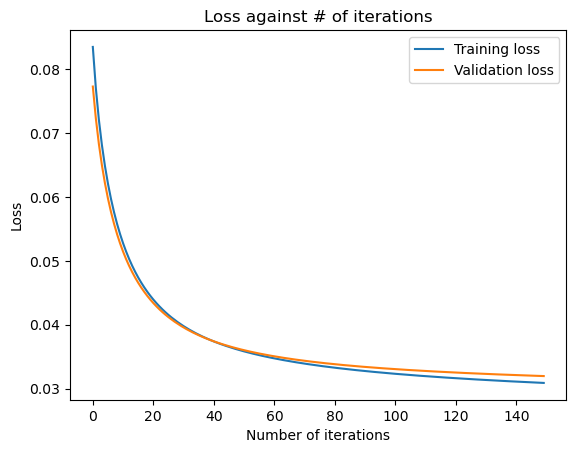

In [4]:
learner.learn()
learner.plot_losses()

### Interpreting results

Let us find out which movies are most popular generally speaking. We can do this by looking at the movies with the highest bias.

First we load the file 'movies.csv' which contains both the movieIds and the actual name of the movie. Then we call the highest_bias method of the learner, which returns a list of the movieIds with the highest bias. We can then match this with the movie's names.

In [5]:
movies = pd.read_csv('movielens_small/movies.csv')
mvIds_highest_bias = learner.highest_bias('movieId')
movies[movies['movieId'].isin(mvIds_highest_bias)]

,movieId,title,genres
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
461,527,Schindler's List (1993),Drama|War
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
659,858,"Godfather, The (1972)",Crime|Drama
900,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller


These are all pretty good movies!

## Testing on the Jester dataset

This is a dataset of joke ratings, available at https://eigentaste.berkeley.edu/dataset/. We use Dataset 1. Each column represents a certain joke, while each row contains joke ratings of a given person. 

### Importing the Jester dataset

In [6]:
dfs = []
for i in range(1,4):
    dfs.append(pd.read_excel(f'jester/jester-data-{i}.xls', header=None))
df_matrix = pd.concat(dfs, axis=0)

# Delete the first column, which contains the number of ratings in the given row
del df_matrix[0]

# According to the dataset description, the value '99.00' represents a missing entry
df_matrix = df_matrix.replace(99.,np.nan)

# Convert from a matrix format to a row-based format
df = df_matrix.stack().reset_index()
df.columns = ['personId', 'jokeId', 'rating']

# Make sure that predictions are in the interval [0,1] instead of [-10,10].
df['rating'] = (df['rating'] + 10)/20

df.head(10)

,personId,jokeId,rating
0,0,1,0.1090
1,0,2,0.9395
2,0,3,0.0170
3,0,4,0.0920
4,0,5,0.1240
5,0,6,0.0750
6,0,7,0.0075
7,0,8,0.7085
8,0,9,0.0510
9,0,10,0.2620


In [7]:
print(f'There are {df.personId.size} entries in the rating matrix.')

There are 4136360 entries in the rating matrix.


### Training the model

Let's create the learner and optimise the coefficients! The dataset is quite big so this might take a while. We stop after a few hundred iterations to prevent overfitting!

In [8]:
learner = collabfilter_learner(df, num_iterations = 400, num_features = 10, learning_rate = 1e-4, ratio = 0.1)

100%|█████████████████████████████████████████| 400/400 [01:45<00:00,  3.80it/s]


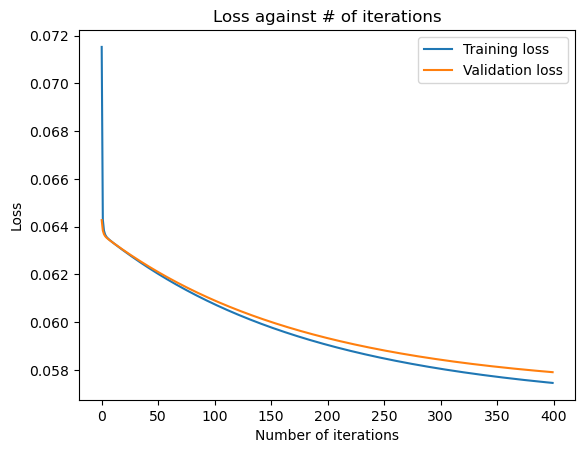

In [9]:
learner.learn()
learner.plot_losses()

### Interpreting results - the best jokes from the dataset

Let us again look at the elements with the highest bias (in this case jokes). Let's take a look at the second-highest rated joke! Classic!

In [10]:
import IPython

jokeId_best = learner.highest_bias('jokeId', n = 3)

IPython.display.HTML(f'jester/jokes/init{jokeId_best[1]}.html')